In [27]:
import os, sys
import gymnasium as gym
import time
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()




Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-6)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-7)
Text Flappy Bird!
Score: 0
----------------------
[     

In [33]:
def epsilon_greedy_policy(Q, state, epsilon, actions):
    if random.uniform(0, 1) < epsilon:
        return random.choice(actions)  # Exploration
    else:
        return max(Q[state], key=Q[state].get)  # Exploitation

def monte_carlo_control(env, num_episodes=5000, gamma=0.9, epsilon=0.1):
    Q = defaultdict(lambda: {0: 0.0, 1: 0.0})  # Action-value function
    rewards = []
    pipes_passed_list = []
    returns = defaultdict(list)  # Stores returns for each state-action pair
    progress_bar = tqdm(range(num_episodes), desc="Training", unit="episode")

    for episode in progress_bar:
        state, _ = env.reset()
        episode_data = []  # Stores (state, action, reward)
        pipes_passed = 0  # Compteur de tuyaux passés
        last_pipe_x = state[1]  # Supposition: la deuxième valeur de state correspond à la position x du tuyau
        total_reward = 0
        
        done = False
        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon, [0, 1])
            next_state, reward, done, _, _ = env.step(action)

            # Vérifier si un tuyau a été passé
            if next_state[1] < last_pipe_x:
                pipes_passed += 1
                last_pipe_x = next_state[1]
            
            episode_data.append((state, action, reward))
            state = next_state
            total_reward += reward

        # Monte Carlo update
        G = 0  # Initialize return
        visited = set()
        for state, action, reward in reversed(episode_data):
            G = gamma * G + reward  # Discounted return
            if (state, action) not in visited:
                visited.add((state, action))
                returns[(state, action)].append(G)
                Q[state][action] = np.mean(returns[(state, action)])  # Update Q-value

        rewards.append(total_reward)
        pipes_passed_list.append(pipes_passed)

        if episode % 100 == 0:
            progress_bar.set_postfix(Episode=episode + 1, Pipes_Passed=pipes_passed, Avg_Reward=np.mean(rewards[-100:]))

    return Q, rewards, pipes_passed_list

def rolling_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

def plot_learning_curves(rewards, pipes_passed_list):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(rolling_average(rewards), label="Avg Reward")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Average Reward per Episode")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(rolling_average(pipes_passed_list), label="Avg Pipes Passed", color='orange')
    plt.xlabel("Episodes")
    plt.ylabel("Pipes Passed")
    plt.title("Average Pipes Passed per Episode")
    plt.legend()
    
    plt.show()

def evaluate_agent(env, Q, num_episodes=100):
    total_rewards = []
    total_pipes = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        pipes_passed = 0
        last_pipe_x = state[1]  # Position x du tuyau

        while not done:
            action = max(Q[state], key=Q[state].get)
            state, reward, done, _, _ = env.step(action)
            total_reward += reward

            # Vérifier si un tuyau a été passé
            if state[1] < last_pipe_x:
                pipes_passed += 1
                last_pipe_x = state[1]

        total_rewards.append(total_reward)
        total_pipes.append(pipes_passed)

    print(f"Average Score: {np.mean(total_rewards)}")
    print(f"Average Pipes Passed: {np.mean(total_pipes)}")


Training: 100%|██████████| 10000/10000 [02:46<00:00, 60.18episode/s, Avg_Reward=120, Episode=9901, Pipes_Passed=7] 


Average Score: 2677.8
Average Pipes Passed: 8.76


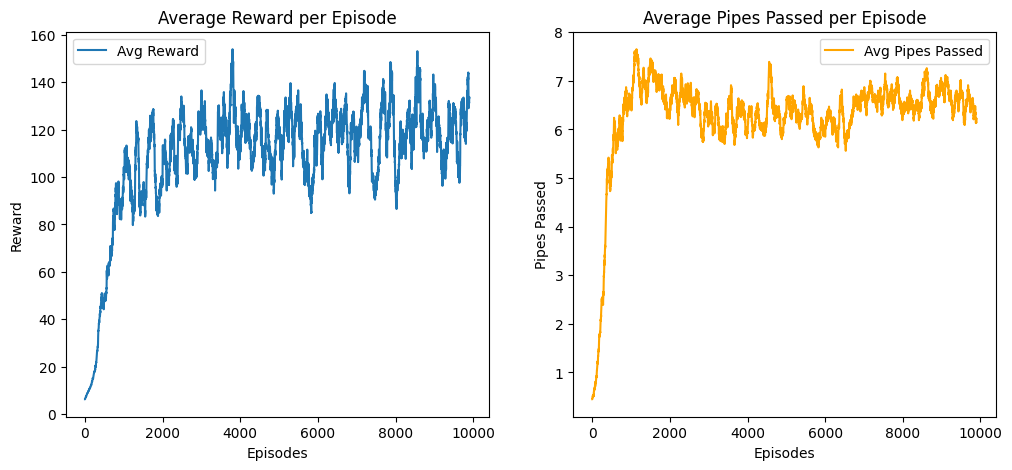

In [34]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
Q, rewards, pipe_passed = monte_carlo_control(env, num_episodes=10000)
evaluate_agent(env, Q) 
plot_learning_curves(rewards, pipe_passed) 

In [ ]:
def sarsa(env, num_episodes=5000, gamma=0.9, alpha=0.1, epsilon=0.1):
    Q = defaultdict(lambda: {0: 0.0, 1: 0.0})  # Action-value function
    rewards = []
    pipes_passed_list = []
    progress_bar = tqdm(range(num_episodes), desc="Training", unit="episode")

    for episode in progress_bar:
        state, _ = env.reset()
        action = epsilon_greedy_policy(Q, state, epsilon, [0, 1])
        pipes_passed = 0  # Compteur de tuyaux passés
        last_pipe_x = state[1]  # Supposition: la deuxième valeur de state correspond à la position x du tuyau
        total_reward = 0

        done = False
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = epsilon_greedy_policy(Q, next_state, epsilon, [0, 1])
            
            # Vérifier si un tuyau a été passé
            if next_state[1] < last_pipe_x:
                pipes_passed += 1
                last_pipe_x = next_state[1]
            
            # SARSA update rule
            Q[state][action] += alpha * (reward + gamma * Q[next_state].get(next_action, 0) - Q[state][action])
            total_reward += reward
            state, action = next_state, next_action

        rewards.append(total_reward)
        pipes_passed_list.append(pipes_passed)

        if episode % 100 == 0:
            progress_bar.set_postfix(Episode=episode + 1, Pipes_Passed=pipes_passed, Avg_Reward=np.mean(rewards[-100:]))

    return Q, rewards, pipes_passed_list

In [ ]:
Sarsa_Q, sarsa_rewards, sarsa_pipes_passed_list = monte_carlo_control(env, num_episodes=5000)
evaluate_agent(env, Sarsa_Q)
plot_learning_curves(sarsa_rewards, sarsa_pipes_passed_list)

Training: 100%|██████████| 5000/5000 [00:22<00:00, 218.29episode/s, Avg_Reward=115, Episode=4901, Pipes_Passed=8]  
